In [1]:
# Importing necessary libraries for EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [9]:
# Loading the data
hist_data = pd.read_csv(r'C:\Users\user\Desktop\Kifiya\Birhan_Energies\data\Brent Oil Futures Historical Data.csv')

In [10]:
# Change the date to appropriate format
hist_data['Date'] = pd.to_datetime(hist_data['Date'], dayfirst=False, errors='coerce')
hist_data.dropna(subset=['Date'], inplace=True)

hist_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-05-03,70.85,70.48,71.54,69.95,249.81K,0.14%
1,2019-05-02,70.75,72.00,72.22,69.68,346.63K,-1.98%
2,2019-05-01,72.18,71.73,72.36,71.30,230.80K,-0.85%
3,2019-04-30,72.80,71.94,73.27,71.73,25.34K,1.05%
4,2019-04-29,72.04,71.56,72.50,71.06,147.41K,-0.15%


In [11]:
# Remove commas from Vol. and Change % and convert to numeric

hist_data['Vol.'] = hist_data['Vol.'].str.replace('K', '').str.replace(',', '').astype(float) * 1000
hist_data['Change %'] = hist_data['Change %'].str.replace('%', '').str.replace(',', '').astype(float) / 100
hist_data.dropna(inplace=True)

In [12]:
# Winsorize outliers
def winsorize(series, limits=(0.01, 0.99)):
    low, high = series.quantile(limits)
    return series.clip(low, high)
hist_data['Change %'] = winsorize(hist_data['Change %'])

In [13]:
# Feature Engineering

# Calculate daily price range
hist_data['Price Range'] = hist_data['High'] - hist_data['Low']

# Calculating rolling volatility
hist_data['Rolling Vola'] = hist_data['Change %'].rolling(window=30).std()
hist_data.dropna(inplace=True)

In [14]:
# Set Index to Date and then Reset to integer index.
hist_data.set_index('Date', inplace=True)
hist_data = hist_data.reset_index(drop=True)

In [15]:
# Split data into train and test sets

train_size = int (len(hist_data)* 0.8)
train, test = hist_data[:train_size], hist_data[train_size:]

# Time Series Modeling

In [16]:
# ARIMA Model

model_arima = ARIMA(train['Change %'], order=(5, 0, 1))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.predict(start=len(train), end=len(hist_data) - 1)
rmse_arima = np.sqrt(mean_squared_error(test['Change %'], predictions_arima))
print(f'ARIMA RMSE: {rmse_arima}')

ARIMA RMSE: 0.022647018942320234


In [17]:
# ARIMAX Model (using other features)
from sklearn.preprocessing import StandardScaler

exog_train = train[['Open', 'High', 'Low', 'Vol.', 'Price Range', 'Rolling Vola']]
exog_test = test[['Open', 'High', 'Low', 'Vol.', 'Price Range', 'Rolling Vola']]

scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)

model_arimax = ARIMA(train['Change %'], exog=exog_train_scaled, order=(5, 0, 1))
model_arimax_fit = model_arimax.fit(method_kwargs={'maxiter': 200})

predictions_arimax = model_arimax_fit.predict(start=len(train), end=len(hist_data) - 1, exog=exog_test_scaled)
rmse_arimax = np.sqrt(mean_squared_error(test['Change %'], predictions_arimax))
print(f'ARIMAX RMSE: {rmse_arimax}')

ARIMAX RMSE: 0.018018802716318658


In [18]:
# GARCH Model (using Change %)
model_garch = arch_model(train['Change %'], vol='GARCH', p=1, q=1)
model_garch_fit = model_garch.fit(disp='off')
forecast_garch = model_garch_fit.forecast(horizon=len(test))
variance_garch = forecast_garch.variance.values[-1, :]
rmse_garch_volatility = np.sqrt(mean_squared_error(test['Change %']**2, variance_garch))
print(f'GARCH Volatility RMSE: {rmse_garch_volatility}')

GARCH Volatility RMSE: 0.0007597574804147387


In [19]:
# LSTM Model (using Change %)
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_train_lstm = scaler_lstm.fit_transform(train[['Change %']])
scaled_test_lstm = scaler_lstm.transform(test[['Change %']])

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 10
trainX, trainY = create_dataset(scaled_train_lstm, look_back)
testX, testY = create_dataset(scaled_test_lstm, look_back)

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

predictions_lstm = model_lstm.predict(testX)
predictions_lstm = scaler_lstm.inverse_transform(np.concatenate((predictions_lstm, np.zeros((len(predictions_lstm), 0))), axis=1))[:, 0]
testY_original = scaler_lstm.inverse_transform(np.concatenate((testY.reshape(-1, 1), np.zeros((len(testY), 0))), axis=1))[:, 0]
rmse_lstm = np.sqrt(mean_squared_error(testY_original, predictions_lstm))
print(f'LSTM RMSE: {rmse_lstm}')

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM RMSE: 0.022747410405115593


# Model Evaluation and Validation

In [ ]:
# Model Comparison
print(f'ARIMA RMSE: {rmse_arima}')
print(f'ARIMAX RMSE: {rmse_arimax}')
print(f'GARCH Volatility RMSE: {rmse_garch_volatility}')
print(f'LSTM RMSE: {rmse_lstm}')

ARIMA RMSE: 0.022647018942320234
ARIMAX RMSE: 0.018018802716318658
GARCH Volatility RMSE: 0.0007597574804147387
LSTM RMSE: 0.022747410405115593


In [21]:
# Time Series Cross-Validation (ARIMA Example)
tscv = TimeSeriesSplit(n_splits=5)
rmses_cv = []
for train_index, test_index in tscv.split(hist_data['Change %']):
    train_cv, test_cv = hist_data['Change %'].iloc[train_index], hist_data['Change %'].iloc[test_index]
    model_cv = ARIMA(train_cv, order=(5, 0, 1))
    model_cv_fit = model_cv.fit()
    predictions_cv = model_cv_fit.predict(start=len(train_cv), end=len(train_cv) + len(test_cv) - 1)
    rmse_cv = np.sqrt(mean_squared_error(test_cv, predictions_cv))
    rmses_cv.append(rmse_cv)
    
print(f'ARIMA Cross-Validation RMSEs: {rmses_cv}')
print(f'Mean ARIMA Cross-Validation RMSE: {np.mean(rmses_cv)}')

ARIMA Cross-Validation RMSEs: [np.float64(0.017773785195736424), np.float64(0.01703830361694419), np.float64(0.023742158501977903), np.float64(0.020676192629492045), np.float64(0.022748520555507957)]
Mean ARIMA Cross-Validation RMSE: 0.020395792099931705


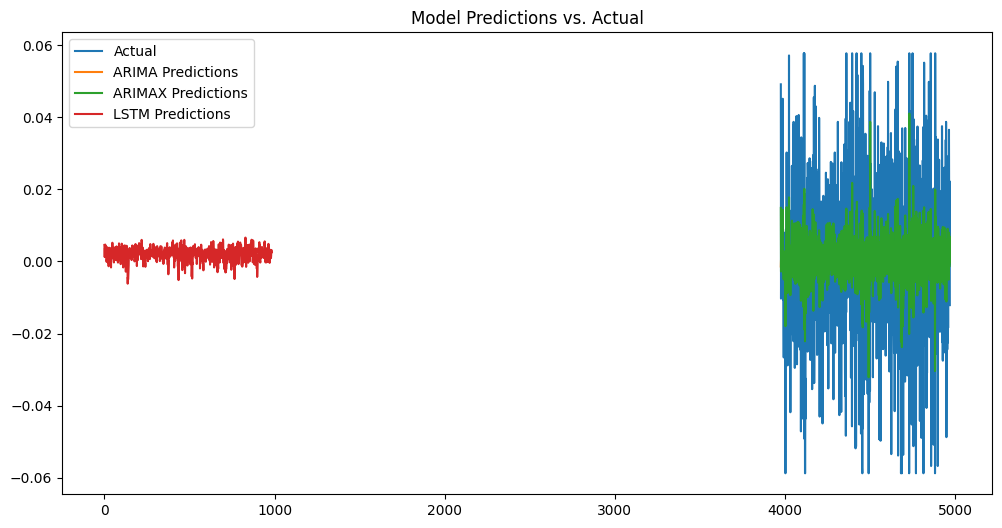

In [22]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test['Change %'], label='Actual')
plt.plot(predictions_arima, label='ARIMA Predictions')
plt.plot(predictions_arimax, label='ARIMAX Predictions')
plt.plot(predictions_lstm, label='LSTM Predictions')
plt.legend()
plt.title('Model Predictions vs. Actual')
plt.show()